# 미션 소개
- 이번 미션에서는 흉부 X-Ray 사진을 바탕으로 폐렴 환자를 구분하는 작업을 수행합니다.
- 이번 미션의 목표는 X-Ray 사진을 입력으로 받아 폐렴 여부를 구분하는 분류(Classification) 모델을 만드는 것입니다. 아래 데이터셋을 활용하여 다양한 이미지 전처리 및 증강 기법과 Transfer Learning과 Fine-Tuning 기법을 실험해보고, 모델의 성능을 평가해 보세요.
# 데이터 소개
- 데이터 링크(Chest X-Ray Images (Pneumonia))
- train: 훈련 데이터
- test: 테스트 데이터
- val: 검증 데이터

# 기본 설정

## 라이브러리 임포트

In [5]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import Dataset
from torch.utils.data import Subset, DataLoader
from torchvision import datasets
from torchvision.transforms import v2

## 디바이스 설정

In [6]:
device = torch.device('mps')
print(device)

mps


# 데이터 가져오기 / 전처리

## pwd 확인

In [7]:
os.getcwd()

'/Users/yoonwogud/Desktop/codeit_ds/Part2'

## 데이터 개수 확인

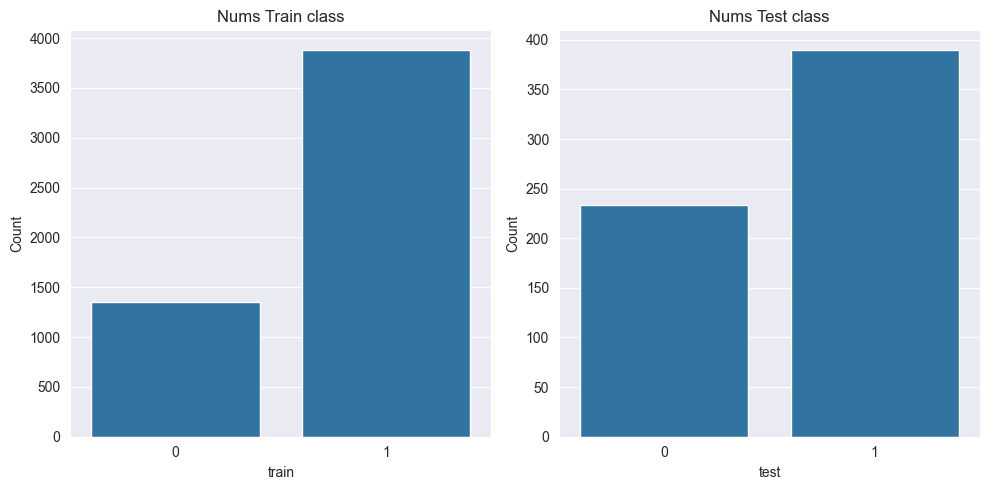

In [8]:
# ImageFolder는 train아래에 클래스가 폴더별로 나뉘어져잇을때 (normal, pneumonia)
train_dataset = datasets.ImageFolder(root='data/chest_xray/train',transform=None)
test_dataset = datasets.ImageFolder(root='data/chest_xray/test', transform=None)

train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]

df_train = pd.DataFrame({'train':train_labels})
df_test = pd.DataFrame({'test':test_labels})

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=df_train, x='train', )
plt.title('Nums Train class')
plt.ylabel('Count', rotation=90)


plt.subplot(1, 2, 2)
sns.countplot(data= df_test, x='test')
plt.title('Nums Test class')
plt.ylabel('Count', rotation=90)

plt.tight_layout()
plt.show()

In [9]:
# train_normal: 1342, 3876
# val_nom: 8, 8
# test_normla: 234, 390

# print(f"train 데이터의 개수: {len(train_dataset)}")
# print(f"test 데이터의 개수: {len(test_dataset)}")
#
# print(f"데이터 세부 정보\n")

# print(f"{train_dataset[0]}")    # 전체 샘플 출력 (image_tensor, label)의 튜플
# print(f"{train_dataset[0][0]}") # 이미지 텐서만 출력 torch.Size([3, H, W])
# print(f"{train_dataset[0][1]}") # 라벨만 출력 정수형 클래스 인덱스 (예: 0 또는 1)
#
# print(f"{train_dataset[0][0][1].shape}") # 첫번재 이미지의 image_tensor의 Green채널
# print(f"{train_dataset[0][0][1][0].shape}") # 첫번재 이미지의 image_tensor의 Green채널의 0번째 행
# print(f"{train_dataset[0][0][1][0][0]}") # 첫번재 이미지의 image_tensor의 Green채널의 0번째 행의 0번째 값

## 데이터 전처리

In [10]:
data_transforms = {
    'train': v2.Compose([
        v2.Resize((224, 224)),                # 이미지 크기 조정
        v2.RandomCrop((196, 196)),
        v2.RandomRotation(10),              #
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.5], [0.5]),           # 정규화
    ]),
    'val': v2.Compose([
        v2.Resize((224, 224)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.5], [0.5]),
    ]),
    'test': v2.Compose([
        v2.Resize((224, 224)),               # 이미지 크기 조정
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.5], [0.5]),           # 정규화
    ])
}

# 전체 이미지 불러오기

# val + train 함.
train_dataset = datasets.ImageFolder(root='data/chest_xray/train',transform=None)
test_dataset = datasets.ImageFolder(root='data/chest_xray/test', transform=None)


# 커스텀 데이터셋 클래스 생성
class PneumoniaDataset(Dataset):
    def __init__(self, input_data, transform=None):
        self.input_data = input_data
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        image, label = self.input_data[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# class ImageFolder(DatasetFolder): 내부 들어가면 이렇게 데이터폴더 상속 받음
# imagefoler -> dataset -> visiondataset 으로 가면 init에 transforms가 있음
# __init__에 transforms를 상속받아서 커스텀 데이터셋 클래스를 안 만들고 파라미터에 넣기만해도됨.

## 데이터 로더로 변환
- (v2로 텐서로 바꿨으니 데이터로더로 변환)

In [11]:
# 8:2로 나누는 길이 구하기
total_size = len(train_dataset)
train_size = round(total_size * 0.8)
val_size = total_size - train_size

# 인덱스 생성
indices = list(range(total_size))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Subset으로 나누기
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

# 커스텀 Dataset에 transform 적용
train_dataset = PneumoniaDataset(train_subset, transform=data_transforms['train'])
val_dataset = PneumoniaDataset(val_subset, transform=data_transforms['val'])
test_dataset = PneumoniaDataset(test_dataset, transform=data_transforms['test'])


# 데이터 로더로 묶기
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


# 모델 구성

## CustomCNN

In [12]:
import torch.nn.functional as F

# Custom CNN 모델 정의
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 클래스 수 설정 (NORMAL, PNEUMONIA)
num_classes = 2


## 학습 레이어 요약

In [13]:
from torchsummary import summary

device = torch.device('cpu')
model = CustomCNN(num_classes).to(device)
summary(model, input_size=(3, 196, 196))
device = torch.device('mps')
model = CustomCNN(num_classes).to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 196, 196]             896
         MaxPool2d-2           [-1, 32, 98, 98]               0
            Conv2d-3           [-1, 64, 98, 98]          18,496
         MaxPool2d-4           [-1, 64, 49, 49]               0
 AdaptiveAvgPool2d-5             [-1, 64, 7, 7]               0
            Linear-6                  [-1, 128]         401,536
            Linear-7                    [-1, 2]             258
Total params: 421,186
Trainable params: 421,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.44
Forward/backward pass size (MB): 17.61
Params size (MB): 1.61
Estimated Total Size (MB): 19.66
----------------------------------------------------------------


# 학습

In [14]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    step = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        all_preds = []
        all_labels = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            step += 1

        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct / total


        train_recall = recall_score(all_labels, all_preds, average='binary')
        train_precision = precision_score(all_labels, all_preds, average='binary')
        train_f1 = f1_score(all_labels, all_preds, average='binary')

        val_loss, val_acc, val_recall, val_precision, val_f1 = evaluate(model, val_loader, criterion)

        wandb.log({
            "train_loss": avg_train_loss,
            "train_acc": train_acc,
            "train_recall": train_recall,
            "train_precision": train_precision,
            "train_f1": train_f1,

            "val_loss": val_loss,
            "val_acc": val_acc,
            "val_recall": val_recall,
            "val_precision": val_precision,
            "val_f1": val_f1,

        })

In [15]:
def evaluate(model, dataloader, loss_fn):
    model.eval()

    losses = []
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            losses.append(loss.item())

            # 예측 결과
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = sum(losses) / len(losses)
    accuracy = correct / total

    recall = recall_score(all_labels, all_preds, average='binary')
    precision = precision_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    return avg_loss, accuracy, recall, precision, f1

In [37]:
loss_fn = nn.CrossEntropyLoss() #
optimizer = optim.Adam(model.parameters(), lr=0.001)

wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="yoonwogud-lab",
    # Set the wandb project where this run will be logged.
    project="Chest-X-Ray-Images-Pneumonia",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.001,
        "architecture": "CustomCNN",
        "epochs": 10,
    },
)

train(model, train_loader, val_loader,loss_fn, optimizer, num_epochs=10)
a,b,c,d,e = evaluate(model, test_loader, loss_fn)
wandb.log({
    "test_loss": a,
    "test_acc": b,
    "test_recall": c,
    "test_precision": d,
    "test_f1": e})
wandb.finish()


test_acc,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_acc,▁▂▂▂▂▃▆█▆█
train_f1,▁▁▂▂▂▃▆█▆█
train_loss,▆█▄▄▃▄▂▁▁▁
train_precision,▁▃▅▃▄▄▅█▅█
train_recall,▄▂▁▃▂▄▇███
+5,...


# 전이 학습

## ResNet18

In [1]:
# 내가 만든 모델 transfer Learning 시키려면 아래처럼 해야됨
# model = CustomCNN(num_classes)

# Feature Extractor 파라미터만 동결
# for param in model.features.parameters():
#     param.requires_grad = False

from torchvision.models import resnet18, ResNet18_Weights

# 이미지넷으로 학습한 resnet18 기본 weight 불러오기
pretrained_model = resnet18(weights=ResNet18_Weights.DEFAULT)


# Feature Extractor Frozen, 역전파할때 파라미터 전달 안하게끔
for param in pretrained_model.parameters():
    param.requires_grad = False


# 분류기 들어오기전 마지막 레이어수
num_features = pretrained_model.fc.in_features
# 분류기 들어오기전 마지막 레이어수 -> 2개로 분류하기
pretrained_model.fc = nn.Linear(num_features, num_classes)

pretrained_model = pretrained_model.to(device)

NameError: name 'nn' is not defined

In [44]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)

# Start a new wandb run to track this script.
wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="yoonwogud-lab",
    # Set the wandb project where this run will be logged.
    project="Chest-X-Ray-Images-Pneumonia",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.001,
        "architecture": "ResNet18",
        "epochs": 10,

    },
)

# 학습 실행
train(pretrained_model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)
a,b,c,d,e = evaluate(pretrained_model, test_loader, loss_fn)
wandb.log({
    "test_loss": a,
    "test_acc": b,
    "test_recall": c,
    "test_precision": d,
    "test_f1": e})
wandb.finish()

test_acc,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_acc,▁▆▆▆▇▇▇███
train_f1,▁▆▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
train_precision,▁▆▇▆▇▇▇███
train_recall,▃▃▁▃▄▄▆▆▆█
+5,...


## GoogleNet

In [16]:
# GoogLeNet 불러오기
from torchvision.models import googlenet, GoogLeNet_Weights

weights = GoogLeNet_Weights.DEFAULT
pretrained_model = googlenet(weights=weights)

# featur exxtractino frozen
for param in pretrained_model.parameters():
    param.requires_grad = False

# 분류기 교체
num_features = pretrained_model.fc.in_features
# 마지막 레이어 -> 2개로 분류
pretrained_model.fc = nn.Linear(num_features, num_classes)

pretrained_model = pretrained_model.to(device)

In [48]:
loss_fn = nn.CrossEntropyLoss() #
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)

wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="yoonwogud-lab",
    # Set the wandb project where this run will be logged.
    project="Chest-X-Ray-Images-Pneumonia",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.001,
        "architecture": "GoogleNet",
        "epochs": 10,
    },
)
# 훈련 시작
train(pretrained_model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)
a,b,c,d,e = evaluate(pretrained_model, test_loader, loss_fn)
wandb.log({
    "test_loss": a,
    "test_acc": b,
    "test_recall": c,
    "test_precision": d,
    "test_f1": e})
wandb.finish()

test_acc,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_acc,▁▆▆▇▇▇▇▇██
train_f1,▁▆▆▇▇▇▇▇██
train_loss,█▄▃▂▂▂▂▁▁▁
train_precision,▁▆▆▇▇▇▇███
train_recall,▅▁▂▇▇▇█▅▆█
+5,...


## AlexNet

In [45]:
from torchvision.models import alexnet, AlexNet_Weights
device = torch.device('cpu')
pretrained_model = alexnet(weights=AlexNet_Weights.DEFAULT)

# 동결
for param in pretrained_model.features.parameters():
    param.requires_grad = False

# 분류기 교체
# 마지가 6번째 레이어에서 2개로 분류할거임
num_features = pretrained_model.classifier[6].in_features
pretrained_model.classifier[6] = nn.Linear(num_features, num_classes)

pretrained_model = pretrained_model.to(device)

In [46]:
loss_fn = nn.CrossEntropyLoss() #
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)

wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="yoonwogud-lab",
    # Set the wandb project where this run will be logged.
    project="Chest-X-Ray-Images-Pneumonia",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.001,
        "architecture": "AlexNet",
        "epochs": 10,
    },
)
# 훈련 시작
train(pretrained_model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)
a,b,c,d,e = evaluate(pretrained_model, test_loader, loss_fn)
wandb.log({
    "test_loss": a,
    "test_acc": b,
    "test_recall": c,
    "test_precision": d,
    "test_f1": e})
wandb.finish()

test_acc,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_acc,▁▆▇▇▇██▇██
train_f1,▁▆▇▇▇██▇██
train_loss,█▃▂▂▂▂▁▁▁▁
train_precision,▁▆▇▇▇██▇██
train_recall,▁▆▇▇▇▇█▇██
+5,...


# Partial Fine-tuning

## ResNet Partial Fine-Tuning

In [49]:
pretrained_model = resnet18(weights=ResNet18_Weights.DEFAULT)

for name, param in pretrained_model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


# 마지막 분류기 교체
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, num_classes)

print("Trainable parameters:")
for name, param in pretrained_model.named_parameters():
    if param.requires_grad:
        print(name)

pretrained_model = pretrained_model.to(device)

Trainable parameters:
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias


In [50]:
loss_fn = nn.CrossEntropyLoss() #
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)

wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="yoonwogud-lab",
    # Set the wandb project where this run will be logged.
    project="Chest-X-Ray-Images-Pneumonia",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.001,
        "architecture": "ResNet18_Partial Fine-Tuning SGD",
        "epochs": 10,
    },
)
# 훈련 시작
train(pretrained_model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)
a,b,c,d,e = evaluate(pretrained_model, test_loader, loss_fn)
wandb.log({
    "test_loss": a,
    "test_acc": b,
    "test_recall": c,
    "test_precision": d,
    "test_f1": e})
wandb.finish()

test_acc,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_acc,▁▆▇▇▇▇████
train_f1,▁▆▇▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
train_precision,▁▆▇▇▇█████
train_recall,▁▃▅▆▆▇▇█▇█
+5,...


# Full Fine-Tuning

## GoogleNet Full Fine-Tuning

In [17]:
pretrained_model = googlenet(weights=GoogLeNet_Weights.DEFAULT)

# 파라미터 갱신 모두 True
for param in pretrained_model.parameters():
    param.requires_grad = True

# 분류기 교체
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, num_classes)

pretrained_model = pretrained_model.to(device)

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.0001)

wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="yoonwogud-lab",
    # Set the wandb project where this run will be logged.
    project="Chest-X-Ray-Images-Pneumonia",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.001,
        "architecture": "GoogleNet Full Fine-Tuning",
        "epochs": 10,
    },
)
# 훈련 시작
train(pretrained_model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)
a,b,c,d,e = evaluate(pretrained_model, test_loader, loss_fn)
wandb.log({
    "test_loss": a,
    "test_acc": b,
    "test_recall": c,
    "test_precision": d,
    "test_f1": e})
wandb.finish()

wandb: Currently logged in as: yoonwogud (yoonwogud-lab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


test_acc,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_acc,▁▅▇▇▇▇████
train_f1,▁▆▇▇▇▇████
train_loss,█▄▂▂▂▁▁▁▁▁
train_precision,▁▅▆▆▇▇█▇██
train_recall,▁▆▇▇▇█████
+5,...


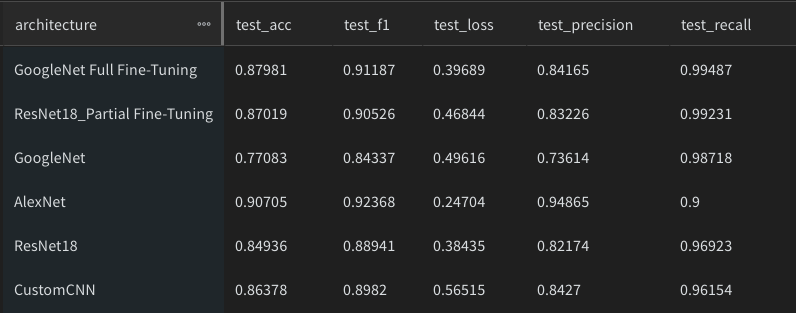